# Analysis on CDKN2A Gene Therapy

### Presented By:QANY



## **Import datas and necessary library**

In [1]:
import pandas as pd
import re
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from ipywidgets import interact, IntSlider
import time
from IPython.display import clear_output
import ipywidgets as widgets
import networkx as nx

articles = pd.read_csv("articles.CDKN2A.csv")
authors = pd.read_csv("authors.CDKN2A.csv")
paper = pd.read_csv("paper_counts.csv")


## **Top researchers who were actively working the last 5 years**

## **Cooperative and competitive relationships between active researchers.**

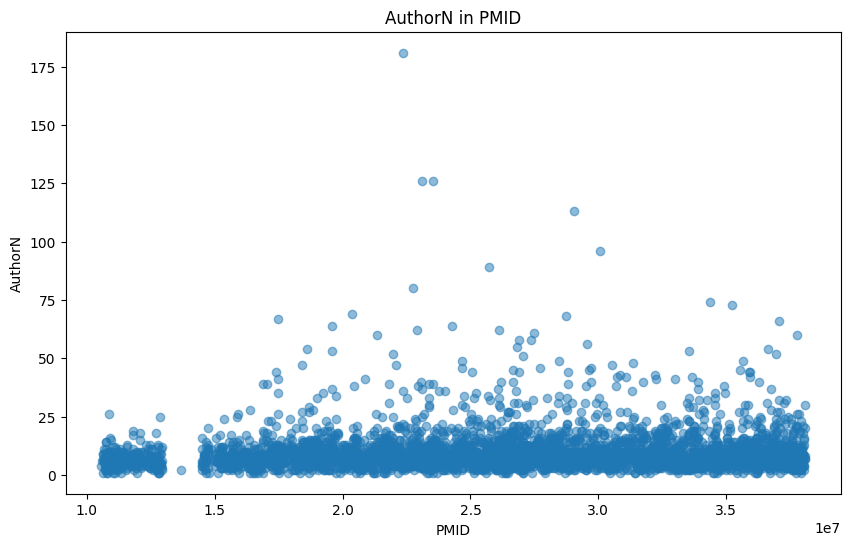

<ipython-input-4-7afa2e58604c>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_authors_data['Author Full Name'] =cleaned_authors_data['AuthorForename'] + ' ' + cleaned_authors_data['AuthorLastname']
<ipython-input-4-7afa2e58604c>:69: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  common_last_authors = set(last_authors[papers_author1]) & set(last_authors[papers_author2])
<ipython-input-4-7afa2e58604c>:69: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  common_last_authors = set(last_authors[papers_author1]) & set(last_authors[papers_author2])
<ipython-input-4-7afa2e58604c>:69: FutureWarning: Passing a set

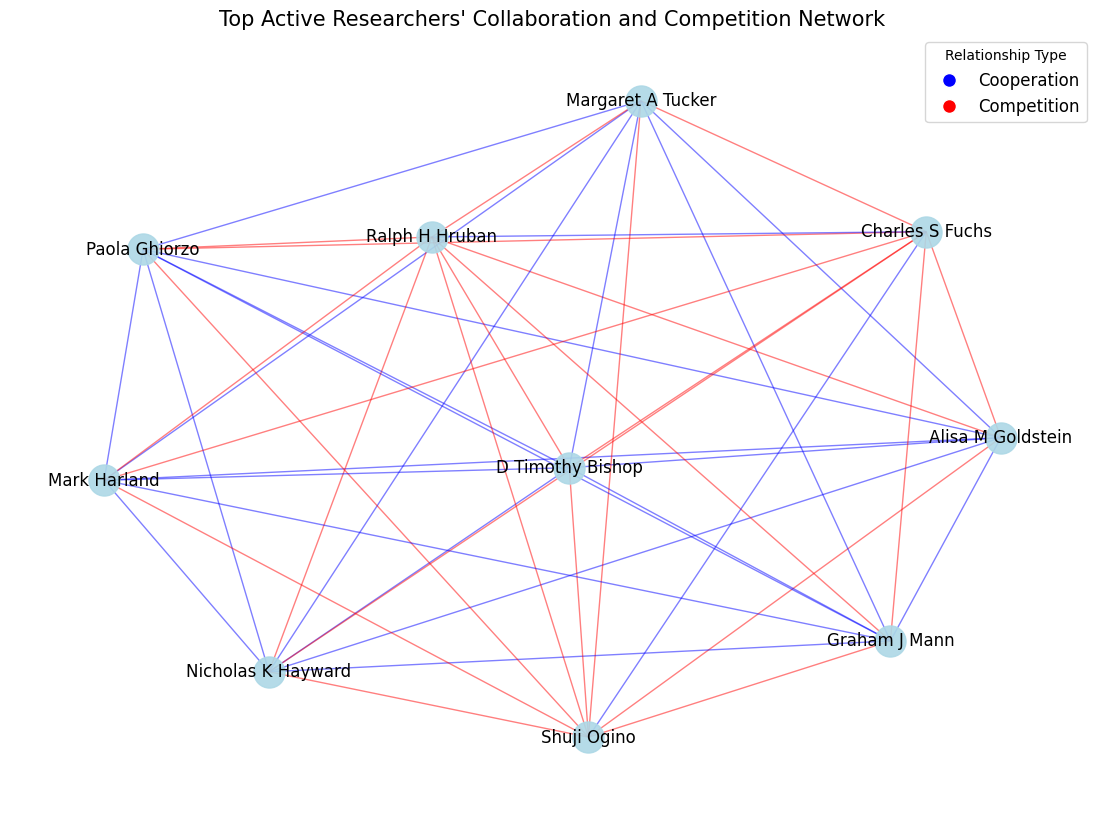

In [4]:
#cleaning data


#scatter to show the author number
result = authors.groupby('PMID')['AuthorN'].agg('max')
result_data = result.reset_index()
#Make scatter plots
x = result_data['PMID']
y = result_data['AuthorN']
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5)
plt.title('AuthorN in PMID')
plt.xlabel('PMID')
plt.ylabel('AuthorN')
plt.show()

# Calculate the number of authors per article (PMID)
author_counts_per_paper = authors.groupby('PMID').size()

# Find the PMID of articles with more than 25 authors
papers_with_many_authors = author_counts_per_paper[author_counts_per_paper > 25].index

# Clear from the data
cleaned_authors_data = authors[~authors['PMID'].isin(papers_with_many_authors)]

# Check the maximum AuthorN value in the cleared data
max_author_n_after_cleaning = cleaned_authors_data['AuthorN'].max()

cleaned_authors_data['Author Full Name'] =cleaned_authors_data['AuthorForename'] + ' ' + cleaned_authors_data['AuthorLastname']


#Make the relationship network
authors['Author Full Name'] = authors['AuthorForename'] + ' ' + authors['AuthorLastname']

# Count the number of times all authors appear
all_author_counts = authors['Author Full Name'].value_counts()

# Get the top 10 most active researchers
top_10_active_researchers = all_author_counts.head(10).index.tolist()

# Sift through the data for the top 10 most active researchers
top_authors_df = cleaned_authors_data[cleaned_authors_data['Author Full Name'].isin(top_10_active_researchers)]

# Create a new diagram
G_top = nx.Graph()

# Add node
G_top.add_nodes_from(top_10_active_researchers)

# Add a partnership edge
for _, group in top_authors_df.groupby('PMID'):
    authors = group['Author Full Name'].tolist()
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            G_top.add_edge(authors[i], authors[j], color='blue')  # 合作关系

# Identify the last author
last_authors = cleaned_authors_data.groupby('PMID').last()['Author Full Name']

# Adds a competitive edge
for i in range(len(top_10_active_researchers)):
    for j in range(i + 1, len(top_10_active_researchers)):
        author1 = top_10_active_researchers[i]
        author2 = top_10_active_researchers[j]
        if not G_top.has_edge(author1, author2):
            papers_author1 = set(cleaned_authors_data[cleaned_authors_data['Author Full Name'] == author1]['PMID'])
            papers_author2 = set(cleaned_authors_data[cleaned_authors_data['Author Full Name'] == author2]['PMID'])
            # uses the intersection operator & to determine if there is a common last author
            common_last_authors = set(last_authors[papers_author1]) & set(last_authors[papers_author2])
            if not common_last_authors:
                G_top.add_edge(author1, author2, color='red')


# Visual network diagram
edge_colors = nx.get_edge_attributes(G_top, 'color').values()

plt.figure(figsize=(14, 10))
# Use spring layout
pos = nx.spring_layout(G_top)
nx.draw_networkx_nodes(G_top, pos, node_color='lightblue', node_size=500, alpha=0.9)
nx.draw_networkx_edges(G_top, pos, edge_color=edge_colors, alpha=0.5)
nx.draw_networkx_labels(G_top, pos, font_size=12, font_family="sans-serif")
legend_labels = {'Cooperation': 'blue', 'Competition': 'red'}
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=key, markersize=10, markerfacecolor=value) for key, value in legend_labels.items()]
plt.legend(handles=legend_handles, title='Relationship Type', loc='upper right', fontsize=12)
plt.title("Top Active Researchers' Collaboration and Competition Network", fontsize=15)
plt.axis('off')
plt.show()


**Number of CDKN2A papers and percentage in PubMed.**

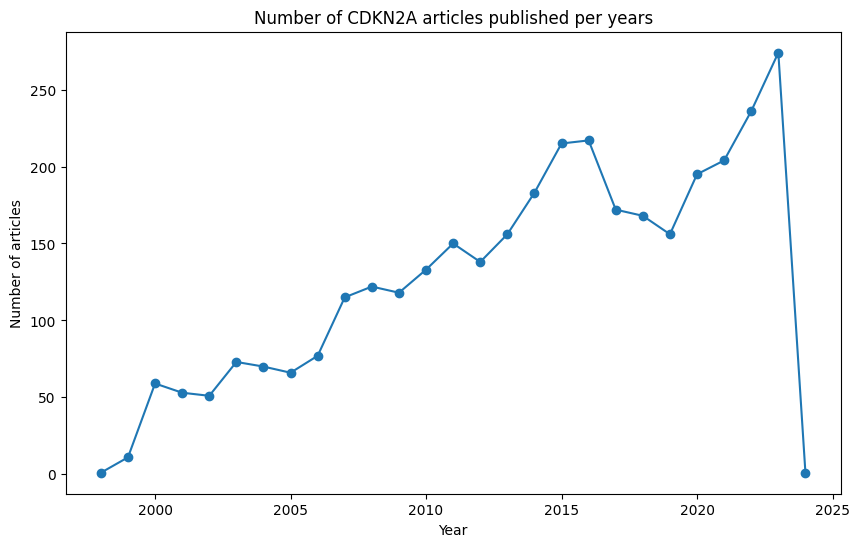

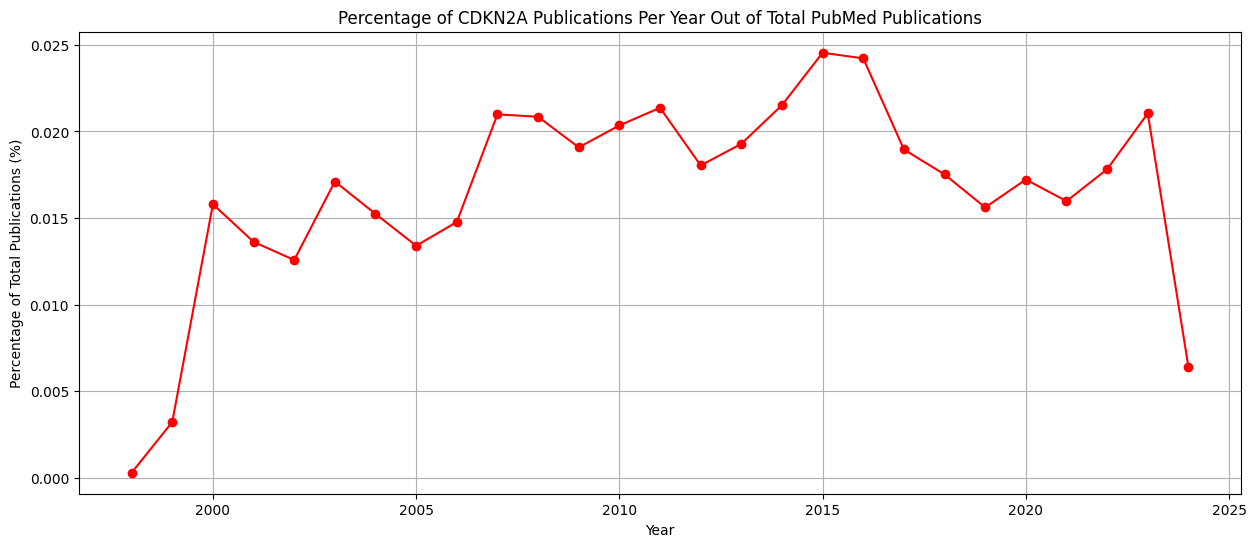

In [6]:
#Number of CDKN2A papers
articles_counts = articles['Year'].value_counts().sort_index()

plt.figure(figsize=(10,6))
plt.plot(articles_counts.index,articles_counts.values, marker = 'o')
plt.xlabel("Year")
plt.ylabel("Number of articles")
plt.title("Number of CDKN2A articles published per years")

#Percentage in PubMed

# Rename the column in paper_counts_data for clarity
paper.rename(columns={'Count': 'TotalPapers'}, inplace=True)

# Count the number of CDKN2A articles per year
CDKN2A = articles.groupby('Year').size().reset_index(name='CDKN2ACount')

# Merge the CDKN2A per year with total paper counts per year
merged_data = pd.merge(CDKN2A, paper, on='Year')

# Calculate the percentage of CDKN2A publications out of total publications per year
merged_data['CDKN2APercentage'] = (merged_data['CDKN2ACount'] / merged_data['TotalPapers']) * 100

# Plotting the percentage trend
plt.figure(figsize=(15, 6))
plt.plot(merged_data['Year'], merged_data['CDKN2APercentage'], marker='o', color='red')
plt.title('Percentage of CDKN2A Publications Per Year Out of Total PubMed Publications')
plt.xlabel('Year')
plt.ylabel('Percentage of Total Publications (%)')
plt.grid(True)
plt.show()

## **Display the number of journals based on the first author and publication count.**

In [4]:
pd.set_option('display.max_colwidth', 100)

# Filtering for only first authors in the 'authors' dataframe
first_authors = authors[authors['AuthorN'] == 1]

# Count the number of articles for each first author
first_author_article_counts = first_authors['AuthorLastname'].value_counts()

# Select the top 20 most active first authors
top_20_first_authors = first_author_article_counts.head(20)

# Merge 'articles' dataframe with 'first_authors' dataframe
merged_first_authors = pd.merge(first_authors, articles, on='PMID')

# Filter the merged dataframe for only the top 20 first authors
top_20_first_authors_articles = merged_first_authors[merged_first_authors['AuthorLastname'].isin(top_20_first_authors.index)]

# For each of the top 20 first authors, find the journal they have published in most frequently
top_journal_per_author = top_20_first_authors_articles.groupby('AuthorLastname')['Journal'].agg(lambda x: x.value_counts().index[0])

# Combine with the count of publications in that journal
top_journal_per_author_count = top_20_first_authors_articles.groupby(['AuthorLastname', 'Journal']).size().reset_index(name='Count')
top_journal_per_author_with_count = top_journal_per_author_count.loc[top_journal_per_author_count.groupby('AuthorLastname')['Count'].idxmax()]

# Formatting the results
formatted_top_journals_per_author = top_journal_per_author_with_count.apply(lambda x: f"{x['AuthorLastname']}: {x['Journal']} ({x['Count']})", axis=1)
formatted_top_journals_per_author.reset_index(drop=True, inplace=True)

# Displaying the formatted results
print(formatted_top_journals_per_author)

0                           Chen: Genes, chromosomes & cancer (2)
1                   Cheng: American journal of human genetics (1)
2                                         Gao: Carcinogenesis (1)
3                      Goldstein: Journal of medical genetics (3)
4                                 Hu: Brain research bulletin (1)
5                 Huang: Breast cancer research and treatment (1)
6          Jiang: Bioscience, biotechnology, and biochemistry (1)
7                                               Kim: PloS one (3)
8                                     Lee: Scientific reports (3)
9     Li: Biochemical and biophysical research communications (2)
10                                               Liu: Cancers (2)
11                                     Lynch: Familial cancer (3)
12                                     Ogino: Human pathology (3)
13                                      Wang: Cancer medicine (2)
14                                  Wu: Frontiers in oncology (2)
15        

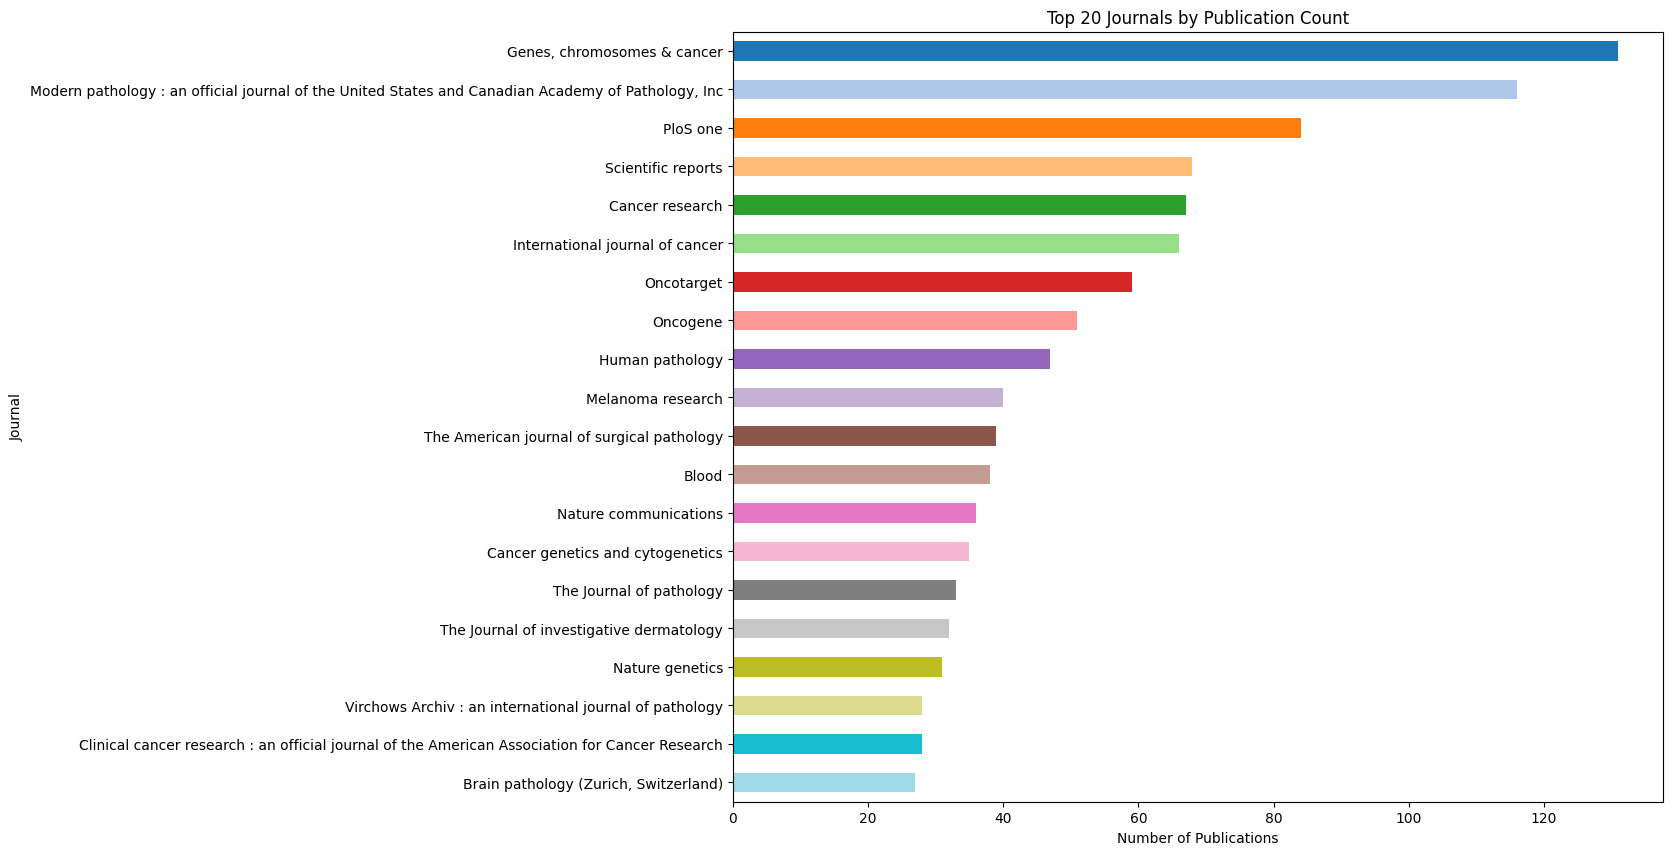

In [5]:
# Counting the number of occurrences of each journal in the 'articles' dataframe
all_journal_counts = articles['Journal'].value_counts()

# Selecting the top 20 most common journals
top_20_journals = all_journal_counts.head(20)

# Creating a horizontal bar plot with distinct colors for each bar
plt.figure(figsize=(12, 10))
colors_top_20_journals = plt.colormaps['tab20'](range(len(top_20_journals)))  # Updated method to obtain colormap
top_20_journals.plot(kind='barh', color=colors_top_20_journals)
plt.title('Top 20 Journals by Publication Count')
plt.ylabel('Journal')
plt.xlabel('Number of Publications')
plt.gca().invert_yaxis()  # Inverting the y-axis so the journal with the most publications is on top
plt.show()

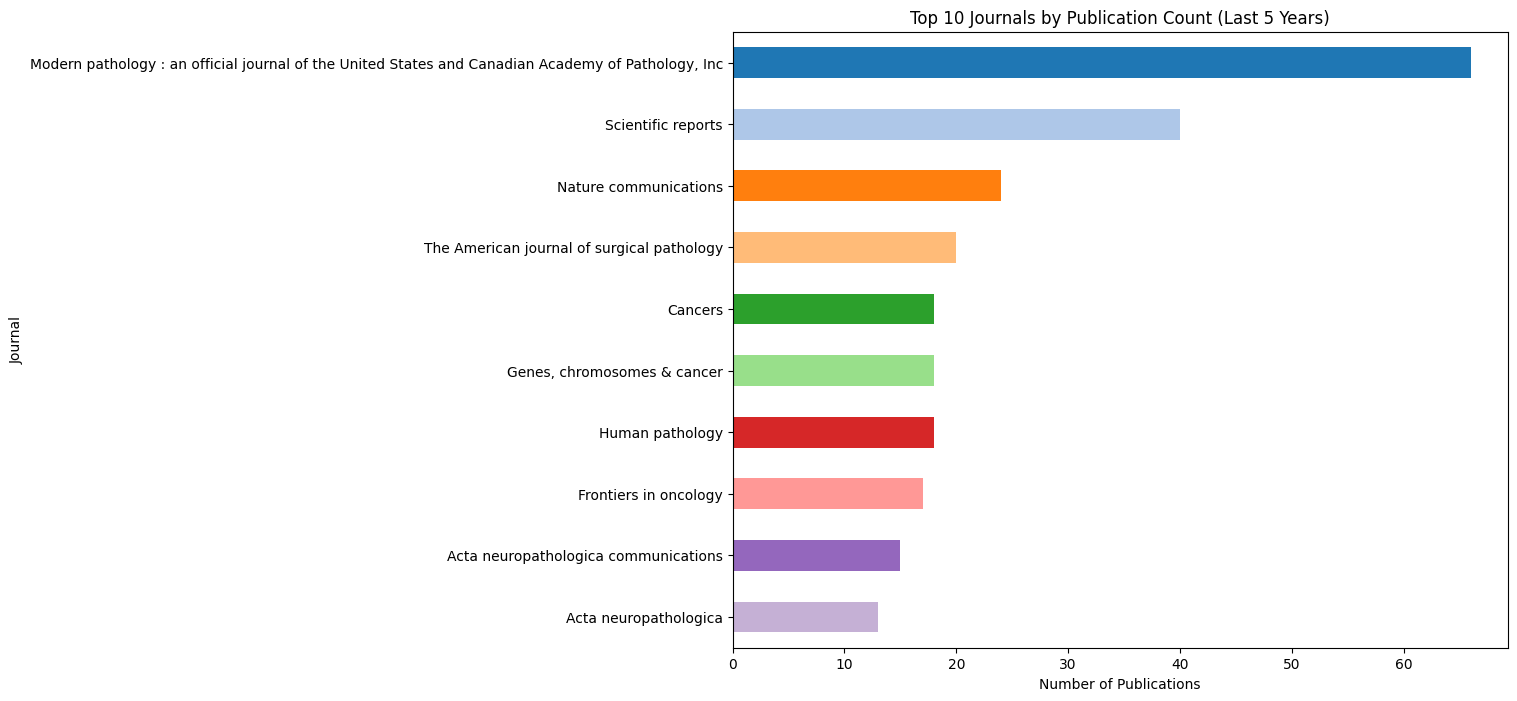

In [6]:
# Filtering the articles dataframe for the last five years (2019-2023)
recent_articles_5y = articles[articles['Year'] >= 2019]

# Counting the number of occurrences of each journal in recent articles
recent_journal_counts_5y = recent_articles_5y['Journal'].value_counts()

# Selecting the top 10 most common journals in the last five years
top_10_recent_journals_5y = recent_journal_counts_5y.head(10)

# Creating a horizontal bar plot with distinct colors for the top 10 journals
plt.figure(figsize=(10, 8))
colors_recent_articles_5y = plt.get_cmap('tab20')(range(len(top_10_recent_journals_5y)))
top_10_recent_journals_5y.plot(kind='barh', color=colors_recent_articles_5y)
plt.title('Top 10 Journals by Publication Count (Last 5 Years)')
plt.ylabel('Journal')
plt.xlabel('Number of Publications')
plt.gca().invert_yaxis()  # Inverting the y-axis so the journal with the most publications is on top
plt.show()

## **Visualization of the number of authors and article regions.**

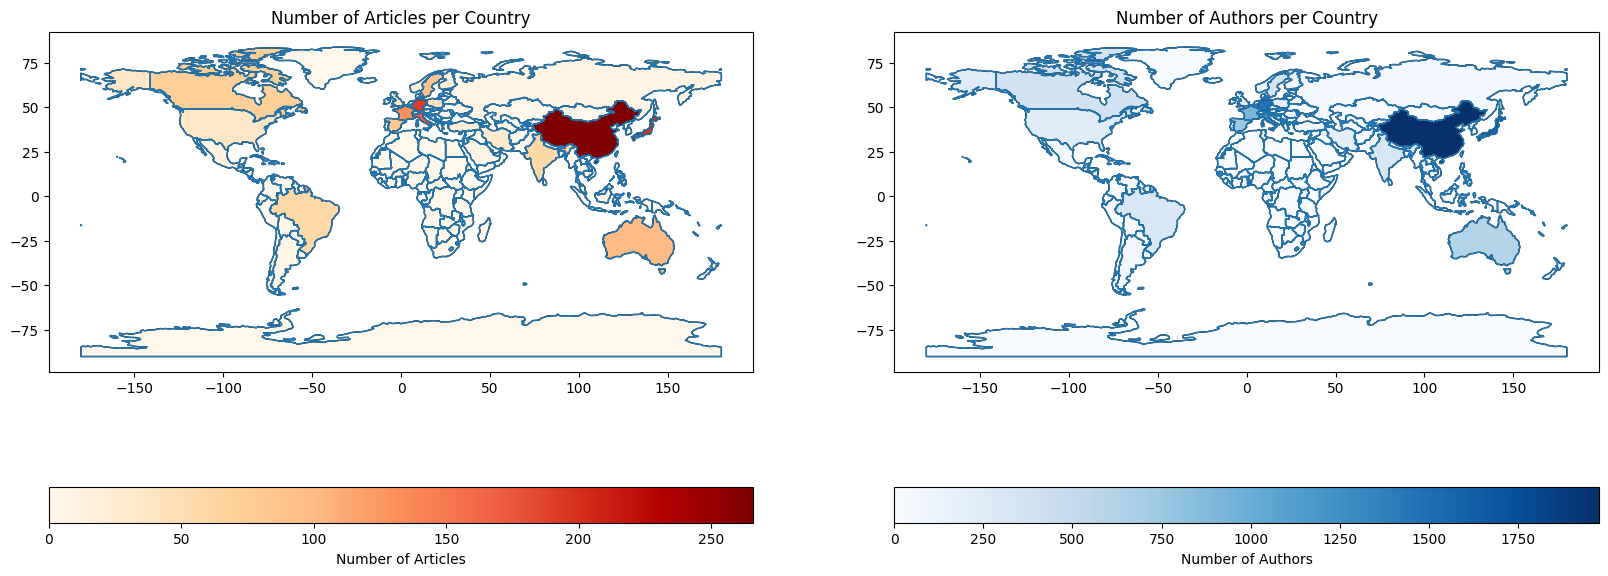

In [2]:
def extract_country(affiliation):
    """
    Extract country name from author’s affiliation information
    从作者单位信息中提取国家名。
    """
    if pd.isna(affiliation):
        return "Unknown"
    try:
        country = affiliation.split(',')[-1].strip()
        country = re.sub(r"(University|Institute|Hospital|Department|College|School).*$", "", country).strip()
        return country
    except:
        return "Unknown"

# # Define function to clean extracted country names
# 定义函数以清理提取出的国家名
def clean_country_name(country):
    """
    Clean the extracted country names
    清理提取出的国家名。
    """
    country = re.sub(r"\..*|\s\-\s.*", "", country)
    return country

# Apply function to relevant columns
# 应用函数到相关列
articles['articles_country'] = articles['FirstAuthorAffiliation'].apply(extract_country).apply(clean_country_name)
authors['authors_country'] = authors['AuthorAffiliation'].apply(extract_country).apply(clean_country_name)

# Group by country and count the number of articles and authors
# 按国家分组并计算文章和作者的数量
articles_count = articles['articles_country'].value_counts().reset_index()
articles_count.columns = ['Country', 'ArticleCount']

authors_count = authors['authors_country'].value_counts().reset_index()
authors_count.columns = ['Country', 'AuthorCount']

# Use geopandas to read the downloaded .shp file
# 使用 geopandas 读取下载的 .shp 文件
world = gpd.read_file('mapdata/ne_110m_admin_0_countries.shp')

# Merge count with world map data
# 将计数与世界地图数据合并
world = world.merge(articles_count, left_on='ADMIN', right_on='Country', how='left')
world = world.merge(authors_count, left_on='ADMIN', right_on='Country', how='left')

# Fill NaN values ​​with 0
# 用0填充NaN值
world['ArticleCount'] = world['ArticleCount'].fillna(0)
world['AuthorCount'] = world['AuthorCount'].fillna(0)

# Draw the map: number of articles and number of authors
# 绘制地图：文章数量和作者数量
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Article count map
# 文章数量地图
world.boundary.plot(ax=ax[0], linewidth=1)
world.plot(column='ArticleCount', ax=ax[0], legend=True,
           legend_kwds={'label': "Number of Articles", 'orientation': "horizontal"},
           cmap='OrRd', edgecolor='black')
ax[0].set_title('Number of Articles per Country')

# Map of number of authors
# 作者数量地图
world.boundary.plot(ax=ax[1], linewidth=1)
world.plot(column='AuthorCount', ax=ax[1], legend=True,
           legend_kwds={'label': "Number of Authors", 'orientation': "horizontal"},
           cmap='Blues', edgecolor='black')
ax[1].set_title('Number of Authors per Country')

plt.show()

In [3]:
print(world.columns)

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_IT', 'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA',
       'geometry', 'Country_x', 'ArticleCount', 'Country_y', 'AuthorCount'],
      dtype='object', length=173)


In [8]:
#Create a basic map
# 创建基本地图
m = folium.Map(
    location = [0, 0], # Set the map center position coordinates [latitude, longitude] # 设定地图中心位置坐标 [纬度, 经度] 
    zoom_start = 2, # Set initial zoom level # 设定初始缩放级别 
    min_zoom = 2, # Set minimum zoom level # 设定最小缩放级别 
    max_bounds = True, # Turn on the maximum boundary limit of the map # 开启地图最大边界限制
    min_lon = -180, # Set the minimum longitude value # 设定最小经度值
    max_lon = 180, # Set the maximum longitude value # 设定最大经度值
    min_lat = -90, # Set the minimum latitude value # 设定最小纬度值
    max_lat = 90 # Set the maximum latitude value # 设定最大纬度值
)

# Convert GeoDataFrame to GeoJSON
# 将 GeoDataFrame 转换为 GeoJSON
world_geojson = world.to_json()

# Add a layer using GeoJSON data
# 添加一个图层，使用 GeoJSON 数据
folium.Choropleth(
    geo_data=world_geojson,
    name='choropleth',
    data=world,
    columns=['ADMIN', 'ArticleCount'],
    key_on='feature.properties.ADMIN',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    line_weight=0.3,
    legend_name='Number of Articles'
).add_to(m)

# Add tooltip
# 添加工具提示
folium.GeoJson(
    world_geojson,
    name='Countries',
    tooltip=folium.GeoJsonTooltip(
        fields=['ADMIN', 'ArticleCount', 'AuthorCount'],
        aliases=['Country', 'Number of Articles', 'Number of Authors'],
        localize=True
    )
).add_to(m)

# Save map as HTML file
# 保存地图为 HTML 文件
m.save('my_map.html')

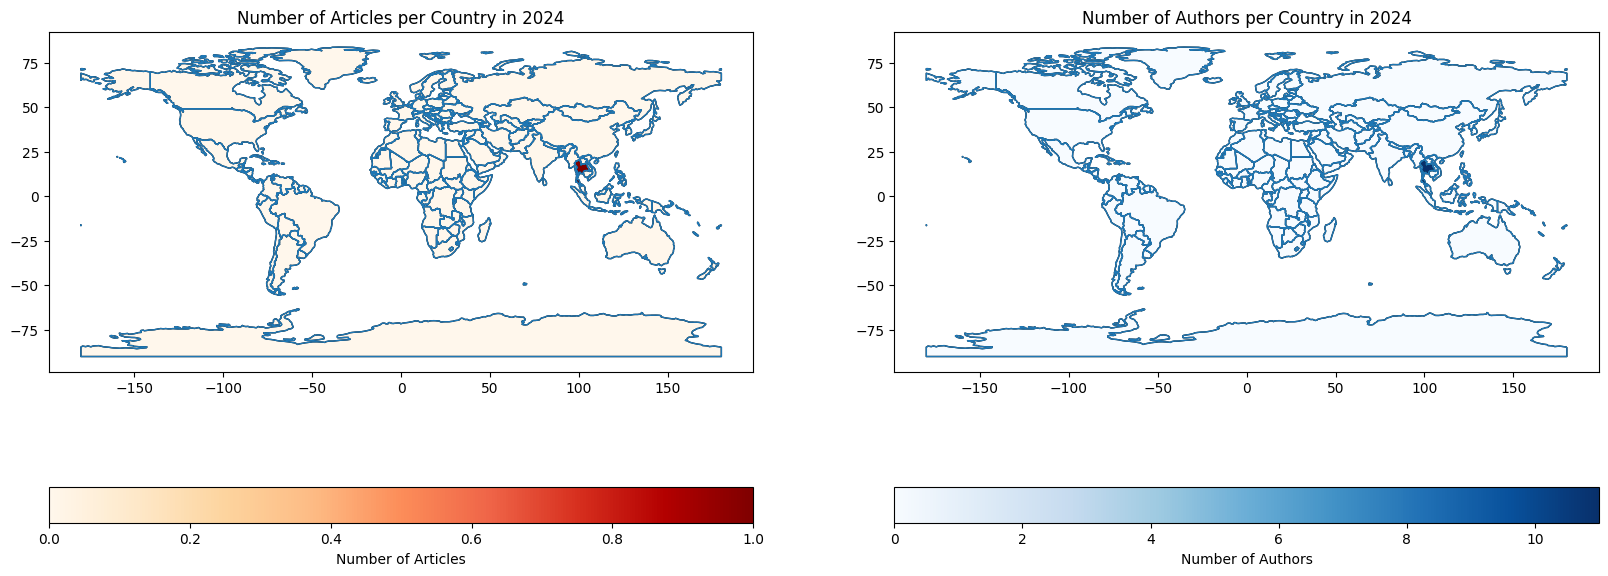

In [7]:
# Define the function for drawing the map
# 定义绘制地图的函数
def plot_maps_for_year(year, shp_file_path):
    # Filter out data for the selected year
    # 过滤出选定年份的数据
    filtered_articles = articles[articles['Year'] == year]
    filtered_authors = authors[authors['PMID'].isin(filtered_articles['PMID'])]
    
    # Group by country and count the number of articles and authors
    # 按国家分组并计算文章和作者的数量
    articles_count_r = filtered_articles['articles_country'].value_counts().reset_index()
    articles_count_r.columns = ['Country', 'ArticleCount']
    authors_count_r = filtered_authors['authors_country'].value_counts().reset_index()
    authors_count_r.columns = ['Country', 'AuthorCount']
    
    # Use geopandas to read .shp files
    # 使用 geopandas 读取 .shp 文件
    world = gpd.read_file('mapdata/ne_110m_admin_0_countries.shp')
    
    # Merge count with world map data
    # 将计数与世界地图数据合并
    world = world.merge(articles_count_r, left_on='ADMIN', right_on='Country', how='left')
    world = world.merge(authors_count_r, left_on='ADMIN', right_on='Country', how='left')
    
    # Fill NaN values ​​with 0
    # 用0填充NaN值
    world['ArticleCount'] = world['ArticleCount'].fillna(0)
    world['AuthorCount'] = world['AuthorCount'].fillna(0)
    
    # Draw the map: number of articles and number of authors
    # 绘制地图：文章数量和作者数量
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    # Article count map
    # 文章数量地图
    world.boundary.plot(ax=ax[0], linewidth=1)
    world.plot(column='ArticleCount', ax=ax[0], legend=True,
               legend_kwds={'label': "Number of Articles", 'orientation': "horizontal"},
               cmap='OrRd', edgecolor='black')
    ax[0].set_title(f'Number of Articles per Country in {year}')
    
    # Map of number of authors
    # 作者数量地图
    world.boundary.plot(ax=ax[1], linewidth=1)
    world.plot(column='AuthorCount', ax=ax[1], legend=True,
               legend_kwds={'label': "Number of Authors", 'orientation': "horizontal"},
               cmap='Blues', edgecolor='black')
    ax[1].set_title(f'Number of Authors per Country in {year}')

    plt.show()

# Get the year range
# 获取年份范围
year_range = articles['Year'].unique()
year_range.sort()

#Set the path to the .shp file
# 设置.shp文件的路径
shp_file_path = 'mapdata\ne_110m_admin_0_countries.shp'

# Automatically display data for each year in rotation
# 自动轮流显示每年的数据
for year in year_range:
    clear_output(wait=True)  # Clear old output # 清除旧的输出
    plot_maps_for_year(year, shp_file_path)
    plt.show()
    time.sleep(0.5)  # Each update interval is 0.5 seconds # 每次更新间隔0.5秒


In [8]:
# Define interactive controls to manually select years
# 定义交互式控件以手动选择年份
def interactive_map(year):
    clear_output(wait=True)
    plot_maps_for_year(year, shp_file_path)
    plt.show()

# Create an interactive slider
# 创建交互式滑块
year_slider = widgets.IntSlider(min=min(year_range), max=max(year_range), step=1, value=min(year_range))
widgets.interactive(interactive_map, year=year_slider)  

interactive(children=(IntSlider(value=1998, description='year', max=2024, min=1998), Output()), _dom_classes=(…

## **Visualization of the review papers**